In [14]:
from datetime import datetime, timedelta
import glob

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import numpy as np

from helpers_data import thresholds, load_data, load_ssn, load_cme_rate, load_lasco_downtime

# Load data

In [7]:
rss = '20'
def get_data(observatory):
    files = sorted(glob.glob(f'/Volumes/Work/open_fline_results/{observatory}/{rss}/*.npz'))
    print(f'{observatory}:', len(files))
    data = load_data(files)
    data.name = observatory
    return data

In [8]:
gong_data = get_data('gong')

gong: 190


In [9]:
solis_data = get_data('solis')

solis: 163


In [10]:
kpvt_data = get_data('kpvt')

kpvt: 377


In [11]:
mdi_data = get_data('mdi')

mdi: 175


Load SSN
---

In [13]:
ssn = load_ssn()

Load CMEs
---

In [15]:
cmes = load_cme_rate()
lasco_dtime = load_lasco_downtime()
lasco_dtime = lasco_dtime.reindex(cmes.index)
cmes['n_norm'] = cmes['n'] / (1 - lasco_dtime['dt'] / timedelta(days=25)).values

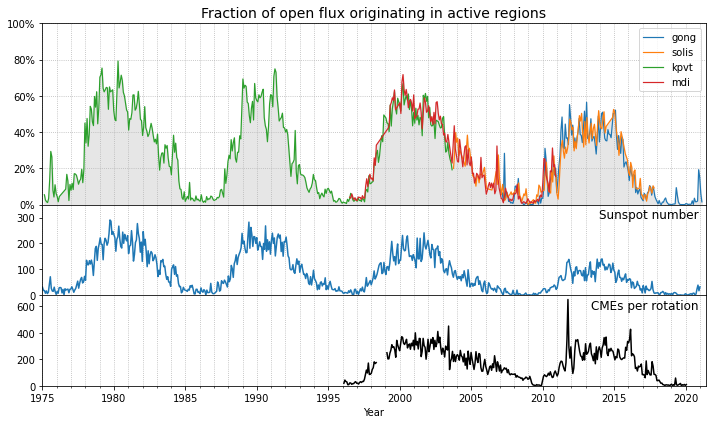

In [18]:
fig, axs = plt.subplots(nrows=3, figsize=(10, 6),
                        sharex=True,
                        gridspec_kw={'height_ratios': [2, 1, 1], 'hspace': 0})

ax = axs[0]
for data in [gong_data, solis_data, kpvt_data, mdi_data]:
    b_feet = np.abs(data.loc['b_feet'])
    b_ss = np.abs(data.loc['b_ss'])
    # Calculate flux
    allflux = np.sum(b_ss, axis=1)
    ar_mask = (b_feet > thresholds[data.name])
    ar_flux = np.sum(ar_mask * b_ss, axis=1)
    # Plot flux
    ax.plot(ar_flux.coords['time'], ar_flux.values / allflux.values,
            label=data.name, lw=1.2)
    ax.fill_between(ar_flux.coords['time'], 0, ar_flux.values / allflux.values, color='0.9')

ax.legend()
ax.yaxis.grid(linestyle='dotted')
ax.set_xlim(datetime(1975, 1, 1), datetime.now())
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
ax.set_title('Fraction of open flux originating in active regions',
             size=14)

ax = axs[1]
ssn_resamp = ssn['SSN'].resample('25D').mean()
ax.plot(ssn_resamp.index, ssn_resamp)
ax.set_ylim(bottom=0, top=350)
ax.text(0.99, 0.96,
        'Sunspot number',
        transform=ax.transAxes,
        size=12,
        va='top',
        ha='right')

ax = axs[2]
ax.plot(cmes.index, cmes['n_norm'], color='black')
ax.set_ylim(bottom=0)
ax.text(0.99, 0.96,
        'CMEs per rotation',
        transform=ax.transAxes,
        size=12,
        va='top',
        ha='right')

axs[-1].xaxis.set_major_locator(mdates.YearLocator(5))
axs[-1].xaxis.set_minor_locator(mdates.YearLocator(1))
axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axs[-1].set_xlabel('Year')

[ax.xaxis.grid(which='both', linestyle='dotted') for ax in axs]

fig.tight_layout()
fig.savefig('figs/ar_frac_all_sources.pdf', bbox_inches='tight')

<ipython-input-17-cd4074294a79>:38: RuntimeWarning: invalid value encountered in true_divide
  ratio = np.sum(ar_mask, axis=0) / (np.sum(ch_mask, axis=0) + np.sum(ar_mask, axis=0))


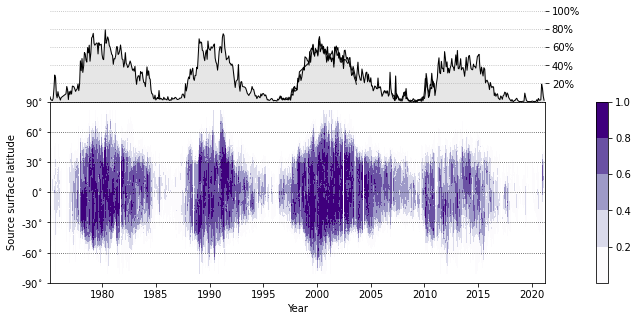

In [17]:
fig, all_axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 5), gridspec_kw={'height_ratios': [1, 2],
                                                                                     'width_ratios': [40, 1]})
fig.subplots_adjust(hspace=0)

axs = all_axs[:, 0]
ax = axs[0]
for data in [gong_data, kpvt_data, mdi_data]:
    b_feet = np.abs(data.loc['b_feet'])
    b_ss = np.abs(data.loc['b_ss'])
    # Calculate flux
    allflux = np.sum(b_ss, axis=1)
    ar_mask = (b_feet > thresholds[data.name])
    ar_flux = np.sum(ar_mask * b_ss, axis=1)
    # Plot flux
    ax.plot(ar_flux.coords['time'], ar_flux.values / allflux.values,
            label=data.name, lw=1, color='k')
    ax.fill_between(ar_flux.coords['time'], 0, ar_flux.values / allflux.values, color='0.9')
    
ax.set_ylim(0, 1)    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_ticks([0.2, 0.4, 0.6, 0.8, 1])
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
ax.yaxis.grid(linestyle='dotted')
ax.yaxis.tick_right()

ax = axs[1]
cmap = plt.get_cmap('Purples', lut=5)
cmap.set_under('white')

for dataset in [kpvt_data, gong_data, mdi_data]:
    dtimes = dataset.coords['time'].values
    for b_feet, lats, dtime in zip(dataset.loc['b_feet'], dataset.loc['lats'], dtimes):
        high_lat = np.abs(lats.values.reshape(360, 180)) > 50
        ar_mask = (np.abs(b_feet.values.reshape(360, 180)) > 30) & (~high_lat)
        ch_mask = (np.abs(b_feet.values.reshape(360, 180)) < 30) | (high_lat)
        ratio = np.sum(ar_mask, axis=0) / (np.sum(ch_mask, axis=0) + np.sum(ar_mask, axis=0))

        corner_x = [dtime, dtime + np.timedelta64(27, 'D')]
        corner_y = np.rad2deg(np.arcsin(np.linspace(-1, 1, 181)))
        X, Y = np.meshgrid(corner_x, corner_y)
        ratio = ratio.reshape(ratio.size, 1)

        I = ax.pcolormesh(X, Y, ratio, rasterized=True, vmin=1e-10, vmax=1, cmap=cmap, shading='auto')

ax.yaxis.grid(linestyle='dotted', zorder=10, color='k', alpha=0.8)
ax.set_ylabel('Source surface latitude')
ax.set_xlabel('Year')
ax.yaxis.set_major_locator(mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90]))
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x}$^{{\circ}}$'))

axs[0].set_xlim(axs[1].get_xlim())

all_axs[0, 1].set_axis_off()
fig.colorbar(I, cax=all_axs[1, 1])
fig.savefig('figs/ar_frac_lats.pdf', bbox_inches='tight')